# Problem Definition

The goal is to predict the sale price of a particular piece of heavy equiment at auction based on it's usage, equipment type, and configuaration. 

# Data

[Blue Book for Bulldozers](https://www.kaggle.com/c/bluebook-for-bulldozers/data)

The data is split into three parts:

- Train.csv is the training set, which contains data through the end of 2011.
- Valid.csv is the validation set, which contains data from January 1, 2012 - April 30, 2012 You make predictions on this set.
- Test.csv is the test set. It contains data from May 1, 2012 - November 2012.

The key fields are in train.csv are:

- SalesID: the uniue identifier of the sale
- MachineID: the unique identifier of a machine.  A machine can be sold multiple times
- saleprice: what the machine sold for at auction (only provided in train.csv)
- saledate: the date of the sale

# Evaluation

The evaluation metric for this model is the RMSLE (root mean squared log error) between the actual and predicted auction prices.

# NOTE

Use the preprocessign function down below

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from matplotlib.dates import DateFormatter, RRuleLocator, MONTHLY, MonthLocator
from matplotlib import ticker

In [2]:
df = pd.read_csv("data/TrainAndValid.csv", low_memory=False, parse_dates=['saledate'])

In [3]:
df.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1139246,66000.0,999089,3157,121,3.0,2004,68.0,Low,2006-11-16,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
1,1139248,57000.0,117657,77,121,3.0,1996,4640.0,Low,2004-03-26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1139249,10000.0,434808,7009,121,3.0,2001,2838.0,High,2004-02-26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1139251,38500.0,1026470,332,121,3.0,2001,3486.0,High,2011-05-19,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1139253,11000.0,1057373,17311,121,3.0,2007,722.0,Medium,2009-07-23,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412698 entries, 0 to 412697
Data columns (total 53 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   SalesID                   412698 non-null  int64         
 1   SalePrice                 412698 non-null  float64       
 2   MachineID                 412698 non-null  int64         
 3   ModelID                   412698 non-null  int64         
 4   datasource                412698 non-null  int64         
 5   auctioneerID              392562 non-null  float64       
 6   YearMade                  412698 non-null  int64         
 7   MachineHoursCurrentMeter  147504 non-null  float64       
 8   UsageBand                 73670 non-null   object        
 9   saledate                  412698 non-null  datetime64[ns]
 10  fiModelDesc               412698 non-null  object        
 11  fiBaseModel               412698 non-null  object        
 12  fi

In [5]:
df.isna().sum()

SalesID                          0
SalePrice                        0
MachineID                        0
ModelID                          0
datasource                       0
auctioneerID                 20136
YearMade                         0
MachineHoursCurrentMeter    265194
UsageBand                   339028
saledate                         0
fiModelDesc                      0
fiBaseModel                      0
fiSecondaryDesc             140727
fiModelSeries               354031
fiModelDescriptor           337882
ProductSize                 216605
fiProductClassDesc               0
state                            0
ProductGroup                     0
ProductGroupDesc                 0
Drive_System                305611
Enclosure                      334
Forks                       214983
Pad_Type                    331602
Ride_Control                259970
Stick                       331602
Transmission                224691
Turbocharged                331602
Blade_Extension     

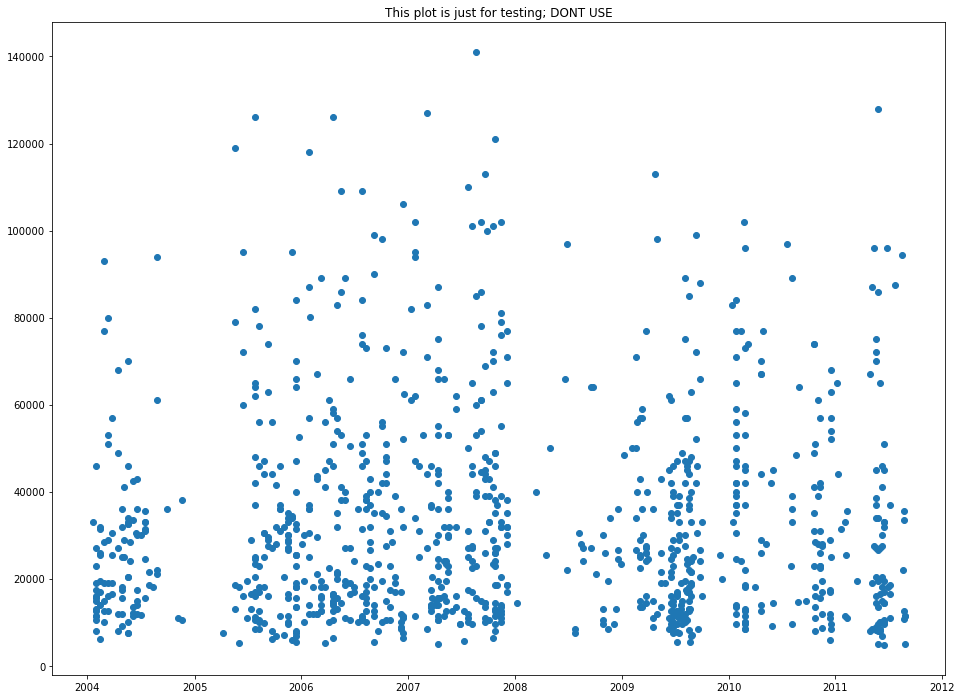

In [6]:
fig, ax = plt.subplots(figsize=(16,12))
ax.plot_date(df["saledate"][:1000], df["SalePrice"][:1000])
ax.set_title("This plot is just for testing; DONT USE")
plt.show()

### It is better to enrich the dataframe with datetime values instead of creating different tiny dataframes for plotting 

In [7]:
x = pd.DataFrame()
x["time"] = df["saledate"].dt.strftime("%b %Y")
x["sales"] = df["SalePrice"]

monthly_total = {}
for t in x["time"].unique():
    monthly_total[t] = x[x["time"] == t]["sales"].sum()

del x    

monthly_total_df = pd.DataFrame(monthly_total.values(), index=monthly_total.keys(), columns=["Total"])
monthly_total_df.index = pd.to_datetime(monthly_total_df.index)
monthly_total_df = monthly_total_df.sort_index()
monthly_total_df

,Total
1989-01-01,2912950.0
1989-02-01,16840150.0
1989-03-01,22619400.0
1989-04-01,18111650.0
1989-05-01,7977100.0
...,...
2011-12-01,152202000.0
2012-01-01,48894473.2
2012-02-01,143867750.0
2012-03-01,153711150.0


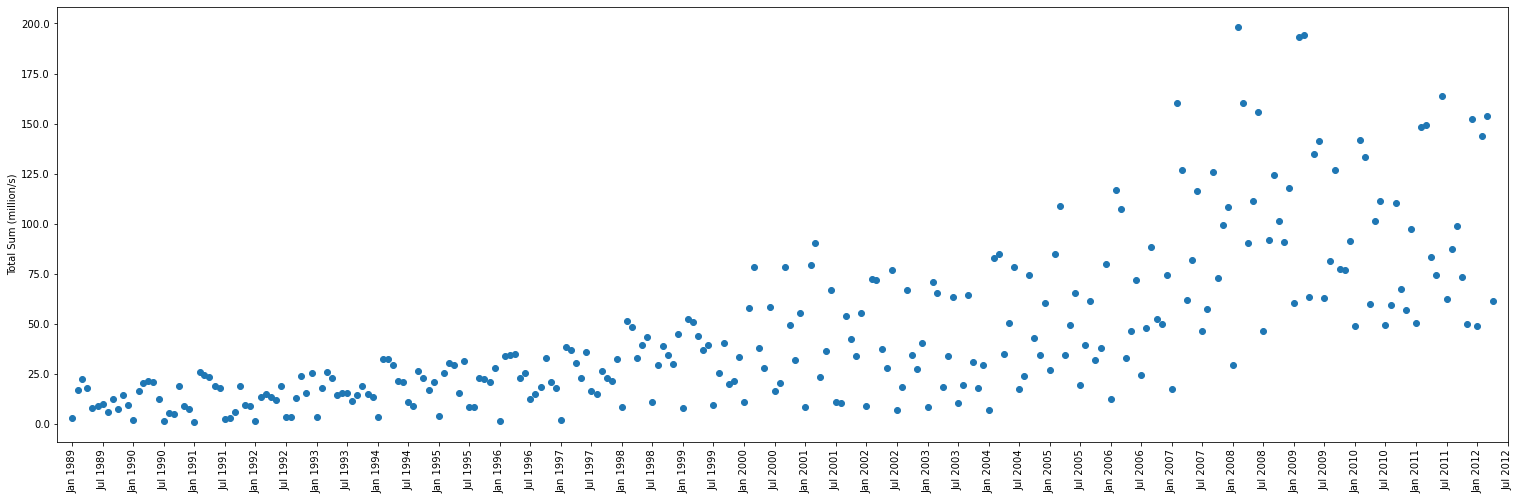

In [8]:
#rule = rrulewrapper(MONTHLY, interval=6)
loc = MonthLocator(range(1, 13, 6))
formatter = DateFormatter('%b %Y')
fig ,ax = plt.subplots(figsize=(26,8))
ax.plot_date(monthly_total_df.index, monthly_total_df["Total"], xdate=True)
ax.xaxis.set_major_locator(loc)
ax.xaxis.set_major_formatter(formatter)
ax.xaxis.set_tick_params(rotation=90)
ax.get_yaxis().set_major_formatter(ticker.FuncFormatter(lambda x, pos: format(int(x)/1000000, ',')))
ax.set_ylabel("Total Sum (million/s)")
ax.set_xlim(left=pd.Timestamp("Oct 1988"), right=pd.Timestamp("July 2012"))
plt.show()
# https://matplotlib.org/3.1.1/gallery/ticks_and_spines/date_demo_rrule.html

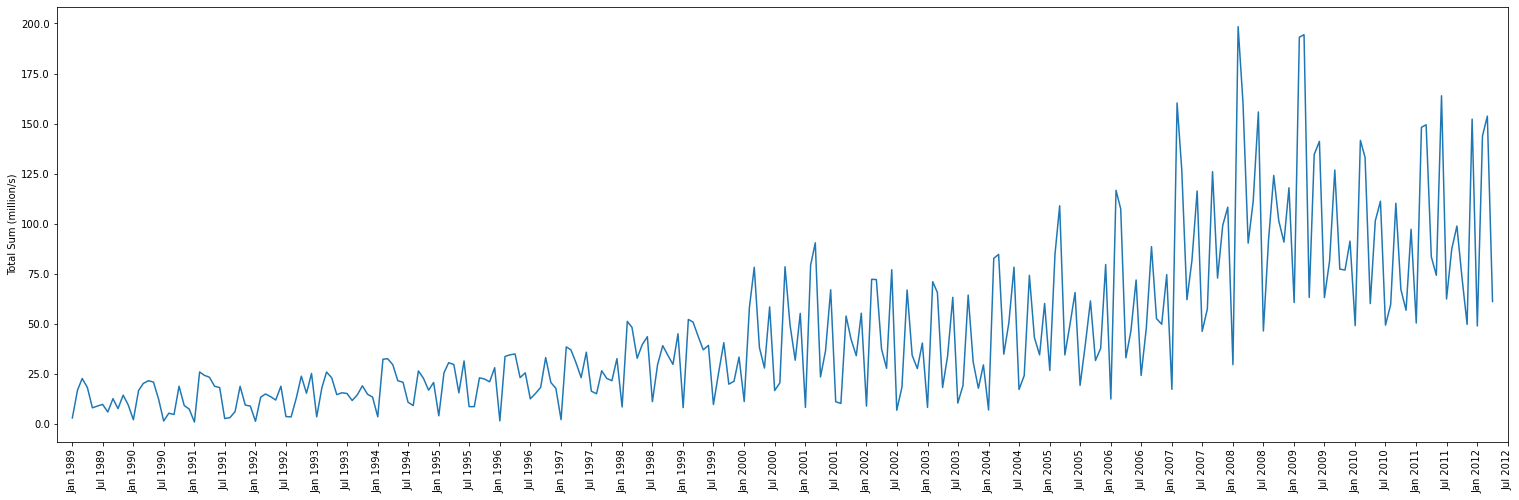

In [9]:
fig, ax = plt.subplots(figsize=(26,8))
lines = plt.plot(monthly_total_df.index, monthly_total_df["Total"])
ax.xaxis.set_major_locator(loc)
ax.xaxis.set_major_formatter(formatter)
ax.xaxis.set_tick_params(rotation=90)
ax.set_xlim(left=pd.Timestamp("Oct 1988"), right=pd.Timestamp("July 2012"))
ax.get_yaxis().set_major_formatter(ticker.FuncFormatter(lambda x, pos: format(int(x)/1000000, ',')))
ax.set_ylabel("Total Sum (million/s)")
plt.show()

In [10]:
format(int(10000000), ',')

'10,000,000'

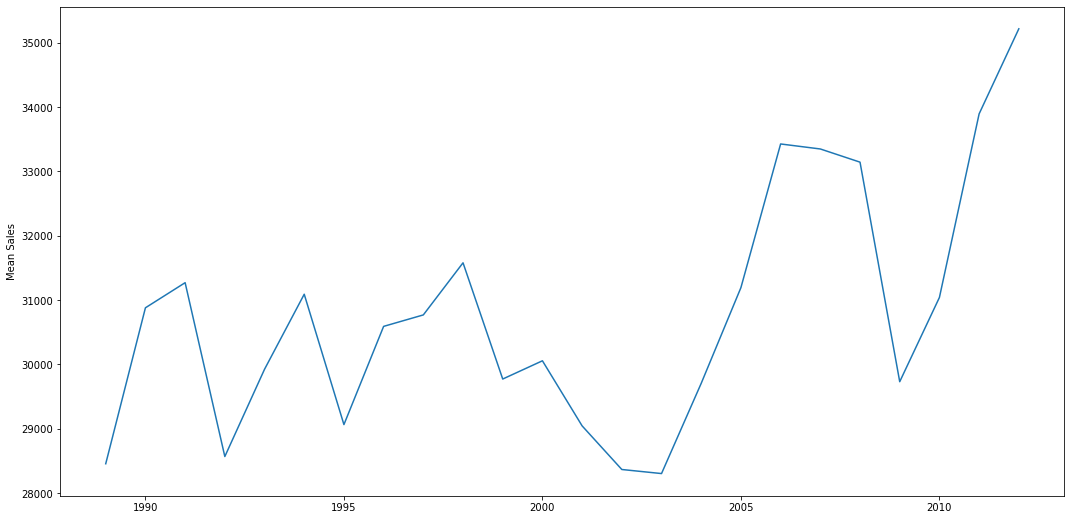

In [11]:
# This way is faster
x = df.groupby(df["saledate"].dt.year).mean()
fig, ax = plt.subplots(figsize=(18, 9))
ax.plot(x.index, x.SalePrice)
ax.set_ylabel("Mean Sales")
plt.show()
del x

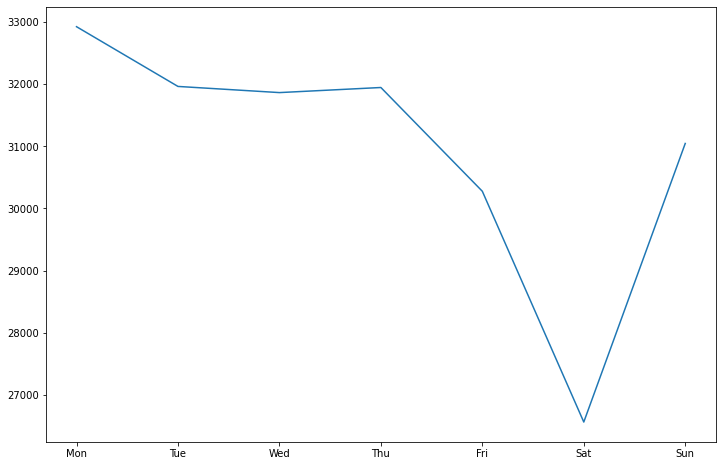

In [12]:
x = df.groupby(df["saledate"].dt.weekday).mean()
x.index = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]

fig, ax = plt.subplots(figsize=(12,8))
ax.plot(x.index, x.SalePrice)
plt.show()
#del x

In [13]:
x = pd.pivot_table(df, values="SalePrice", index=[df["saledate"].dt.year], columns=[df["saledate"].dt.weekday])

x.columns = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
x.fillna(value=0, inplace=True)
x.head()

,Mon,Tue,Wed,Thu,Fri,Sat,Sun
saledate,,,,,,,
1989,25024.025974,28930.614203,26027.394636,31479.504232,27329.166667,20368.731988,0.0
1990,24766.255144,33017.504543,26548.076923,32687.352445,25312.992126,18771.562500,0.0
1991,35398.207885,28057.622210,35841.102757,30805.177346,38108.717949,15537.387387,0.0
1992,39770.491803,28331.204277,32301.659751,27640.963061,28680.270270,26726.099211,0.0
1993,29716.894410,33221.917192,25549.116608,30860.774887,29975.214286,28104.119223,0.0


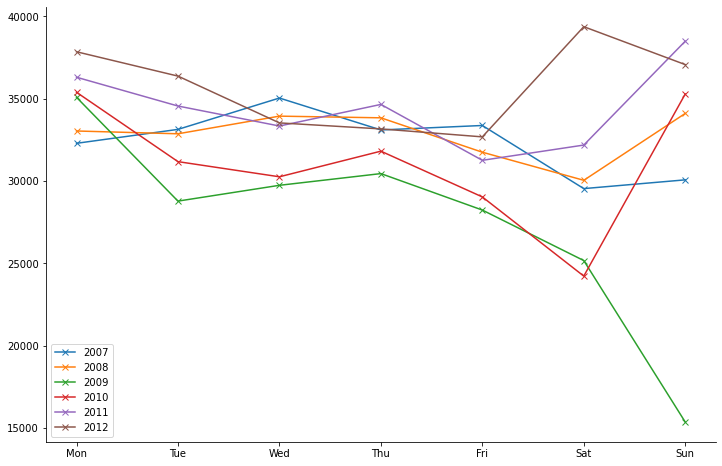

In [14]:
fig, ax = plt.subplots(figsize=(12, 8))
for i, row in x.iterrows():
    if i > 2006:
        ax.plot(row.index, row, "x-", label=i)
        ax.legend()
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
plt.show()
#del x

In [15]:
df.head().T

,0,1,2,3,4
SalesID,1139246,1139248,1139249,1139251,1139253
SalePrice,66000,57000,10000,38500,11000
MachineID,999089,117657,434808,1026470,1057373
ModelID,3157,77,7009,332,17311
datasource,121,121,121,121,121
auctioneerID,3,3,3,3,3
YearMade,2004,1996,2001,2001,2007
MachineHoursCurrentMeter,68,4640,2838,3486,722
UsageBand,Low,Low,High,High,Medium
saledate,2006-11-16 00:00:00,2004-03-26 00:00:00,2004-02-26 00:00:00,2011-05-19 00:00:00,2009-07-23 00:00:00


In [16]:
df.sort_values("saledate", inplace=True)
df_temp = df.copy()

# Enriching DataFrame

In [17]:
df_temp["saleyear"] = df_temp["saledate"].dt.year
df_temp["salemonth"] = df_temp["saledate"].dt.month
df_temp["saleday"] = df_temp["saledate"].dt.day
df_temp["saledayofweek"] = df_temp["saledate"].dt.dayofweek

In [18]:
df_temp.drop("saledate", axis=1, inplace=True)
df_temp.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,...,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls,saleyear,salemonth,saleday,saledayofweek
205615,1646770,9500.0,1126363,8434,132,18.0,1974,NaN,NaN,TD20,...,NaN,None or Unspecified,Straight,None or Unspecified,NaN,NaN,1989,1,17,1
274835,1821514,14000.0,1194089,10150,132,99.0,1980,NaN,NaN,A66,...,NaN,NaN,NaN,NaN,Standard,Conventional,1989,1,31,1
141296,1505138,50000.0,1473654,4139,132,99.0,1978,NaN,NaN,D7G,...,NaN,None or Unspecified,Straight,None or Unspecified,NaN,NaN,1989,1,31,1
212552,1671174,16000.0,1327630,8591,132,99.0,1980,NaN,NaN,A62,...,NaN,NaN,NaN,NaN,Standard,Conventional,1989,1,31,1
62755,1329056,22000.0,1336053,4089,132,99.0,1984,NaN,NaN,D3B,...,NaN,None or Unspecified,PAT,Lever,NaN,NaN,1989,1,31,1


## Converting data to numerical data with catagories

In [19]:
for col, val in df_temp.iteritems():
    if pd.api.types.is_string_dtype(val):
        df_temp[col] = val.astype("category").cat.as_ordered()

In [20]:
df_temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 412698 entries, 205615 to 409203
Data columns (total 56 columns):
 #   Column                    Non-Null Count   Dtype   
---  ------                    --------------   -----   
 0   SalesID                   412698 non-null  int64   
 1   SalePrice                 412698 non-null  float64 
 2   MachineID                 412698 non-null  int64   
 3   ModelID                   412698 non-null  int64   
 4   datasource                412698 non-null  int64   
 5   auctioneerID              392562 non-null  float64 
 6   YearMade                  412698 non-null  int64   
 7   MachineHoursCurrentMeter  147504 non-null  float64 
 8   UsageBand                 73670 non-null   category
 9   fiModelDesc               412698 non-null  category
 10  fiBaseModel               412698 non-null  category
 11  fiSecondaryDesc           271971 non-null  category
 12  fiModelSeries             58667 non-null   category
 13  fiModelDescriptor       

In [21]:
df_temp.isna().sum()/len(df.index)*100

SalesID                      0.000000
SalePrice                    0.000000
MachineID                    0.000000
ModelID                      0.000000
datasource                   0.000000
auctioneerID                 4.879113
YearMade                     0.000000
MachineHoursCurrentMeter    64.258610
UsageBand                   82.149174
fiModelDesc                  0.000000
fiBaseModel                  0.000000
fiSecondaryDesc             34.099269
fiModelSeries               85.784520
fiModelDescriptor           81.871490
ProductSize                 52.485110
fiProductClassDesc           0.000000
state                        0.000000
ProductGroup                 0.000000
ProductGroupDesc             0.000000
Drive_System                74.051970
Enclosure                    0.080931
Forks                       52.092087
Pad_Type                    80.349796
Ride_Control                62.992794
Stick                       80.349796
Transmission                54.444412
Turbocharged

## Filling mission values

In [22]:
for col, content in df_temp.iteritems():
    if pd.api.types.is_numeric_dtype(content):
        df_temp[col + "_was_missing"] = pd.isnull(content)
        if pd.isnull(content).sum():
            df_temp[col] = content.fillna(content.median())

In [23]:
print(df_temp.isna().sum().to_string())

SalesID                                      0
SalePrice                                    0
MachineID                                    0
ModelID                                      0
datasource                                   0
auctioneerID                                 0
YearMade                                     0
MachineHoursCurrentMeter                     0
UsageBand                               339028
fiModelDesc                                  0
fiBaseModel                                  0
fiSecondaryDesc                         140727
fiModelSeries                           354031
fiModelDescriptor                       337882
ProductSize                             216605
fiProductClassDesc                           0
state                                        0
ProductGroup                                 0
ProductGroupDesc                             0
Drive_System                            305611
Enclosure                                  334
Forks        

In [24]:
for col, content in df_temp.iteritems():
    if not pd.api.types.is_numeric_dtype(content):
        df_temp[col+"_was_missing"] = pd.isnull(content)
        df_temp[col] = df_temp[col].cat.codes + 1

In [25]:
print(df_temp.isna().sum().to_string())

SalesID                                 0
SalePrice                               0
MachineID                               0
ModelID                                 0
datasource                              0
auctioneerID                            0
YearMade                                0
MachineHoursCurrentMeter                0
UsageBand                               0
fiModelDesc                             0
fiBaseModel                             0
fiSecondaryDesc                         0
fiModelSeries                           0
fiModelDescriptor                       0
ProductSize                             0
fiProductClassDesc                      0
state                                   0
ProductGroup                            0
ProductGroupDesc                        0
Drive_System                            0
Enclosure                               0
Forks                                   0
Pad_Type                                0
Ride_Control                      

In [26]:
df_temp.to_csv("data/TrainAndValidCleaned1.csv", index=False)

## Training

In [27]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_log_error, mean_absolute_error, r2_score

In [28]:
def rmsle(Y_TRUE, Y_PRED):
    return np.sqrt(mean_squared_log_error(Y_TRUE, Y_PRED))

def score(model):
        TRAIN_PREDS = model.predict(X_TRAIN)
        VALID_PREDS = model.predict(X_VALID)
        scores = {
            "Training mean absolute": mean_absolute_error(Y_TRAIN, TRAIN_PREDS),
            "Valid mean absolute" : mean_absolute_error(Y_VALID, VALID_PREDS),
            "Training root mean": rmsle(Y_TRAIN, TRAIN_PREDS),
            "Valid root mean": rmsle(Y_VALID, VALID_PREDS),
            "Training r2": r2_score(Y_TRAIN, TRAIN_PREDS),
            "Valid r2": r2_score(Y_VALID, VALID_PREDS)
        }
        return scores

In [29]:
percent_load = 10000
TRAIN = df_temp[df_temp["saleyear"] != 2012]
VALID = df_temp[df_temp["saleyear"] == 2012]
X_TRAIN = TRAIN.drop(["SalePrice", "SalePrice_was_missing"], axis=1)
Y_TRAIN = TRAIN["SalePrice"]
X_VALID = VALID.drop(["SalePrice", "SalePrice_was_missing"], axis=1)
Y_VALID = VALID["SalePrice"]

In [30]:
X_TRAIN.shape, Y_TRAIN.shape, X_VALID.shape, Y_VALID.shape

((401125, 110), (401125,), (11573, 110), (11573,))

In [31]:
ideal_model = RandomForestRegressor(n_jobs=-1, 
                                    random_state=22, 
                                    n_estimators=40, 
                                    min_samples_leaf=1,
                                    min_samples_split=14,
                                    max_features=0.5,
                                    max_samples=None)
ideal_model.fit(X_TRAIN, Y_TRAIN)

RandomForestRegressor(max_features=0.5, min_samples_split=14, n_estimators=40,
                      n_jobs=-1, random_state=22)

In [32]:
score(ideal_model)

{'Training mean absolute': 3001.061937748787,
 'Valid mean absolute': 5908.984452527779,
 'Training root mean': 0.1463938429769652,
 'Valid root mean': 0.242679540246509,
 'Training r2': 0.957618202543559,
 'Valid r2': 0.8818348347229747}

## Preprocessign the test data

In [33]:
def preprocess_data(dataframe):
    df = dataframe.copy()
    df["saleyear"] = df["saledate"].dt.year
    df["salemonth"] = df["saledate"].dt.month
    df["saleday"] = df["saledate"].dt.day
    df["saledayofweek"] = df["saledate"].dt.dayofweek
    df.drop("saledate", axis=1, inplace=True)
    
    for col, val in df.iteritems():
        if pd.api.types.is_string_dtype(val):
            df[col] = val.astype("category").cat.as_ordered()
            
    for col, content in df.iteritems():
        if pd.api.types.is_numeric_dtype(content):
            df[col + "_was_missing"] = pd.isnull(content)
            if pd.isnull(content).sum():
                df[col] = content.fillna(content.median())
    
    for col, content in df.iteritems():
        if not pd.api.types.is_numeric_dtype(content):
            df[col+"_was_missing"] = pd.isnull(content)
            df[col] = df[col].cat.codes + 1
    
            
    return df

In [34]:
df_test = pd.read_csv("data/Test.csv", parse_dates=["saledate"])
df_test = preprocess_data(df_test)

In [35]:
TEST_PREDS = ideal_model.predict(df_test)
TEST_PREDS

array([18072.52858304, 14503.01060619, 45122.56094836, ...,
       12992.93041251, 17891.32621915, 25628.46409953])

In [36]:
output = pd.DataFrame()
output["SalesID"] = df_test["SalesID"]
output["SalePrice"] = TEST_PREDS
output.head()

,SalesID,SalePrice
0,1227829,18072.528583
1,1227844,14503.010606
2,1227847,45122.560948
3,1227848,66241.545294
4,1227863,62035.021560


In [37]:
output.to_csv("data/output.csv", index=False)

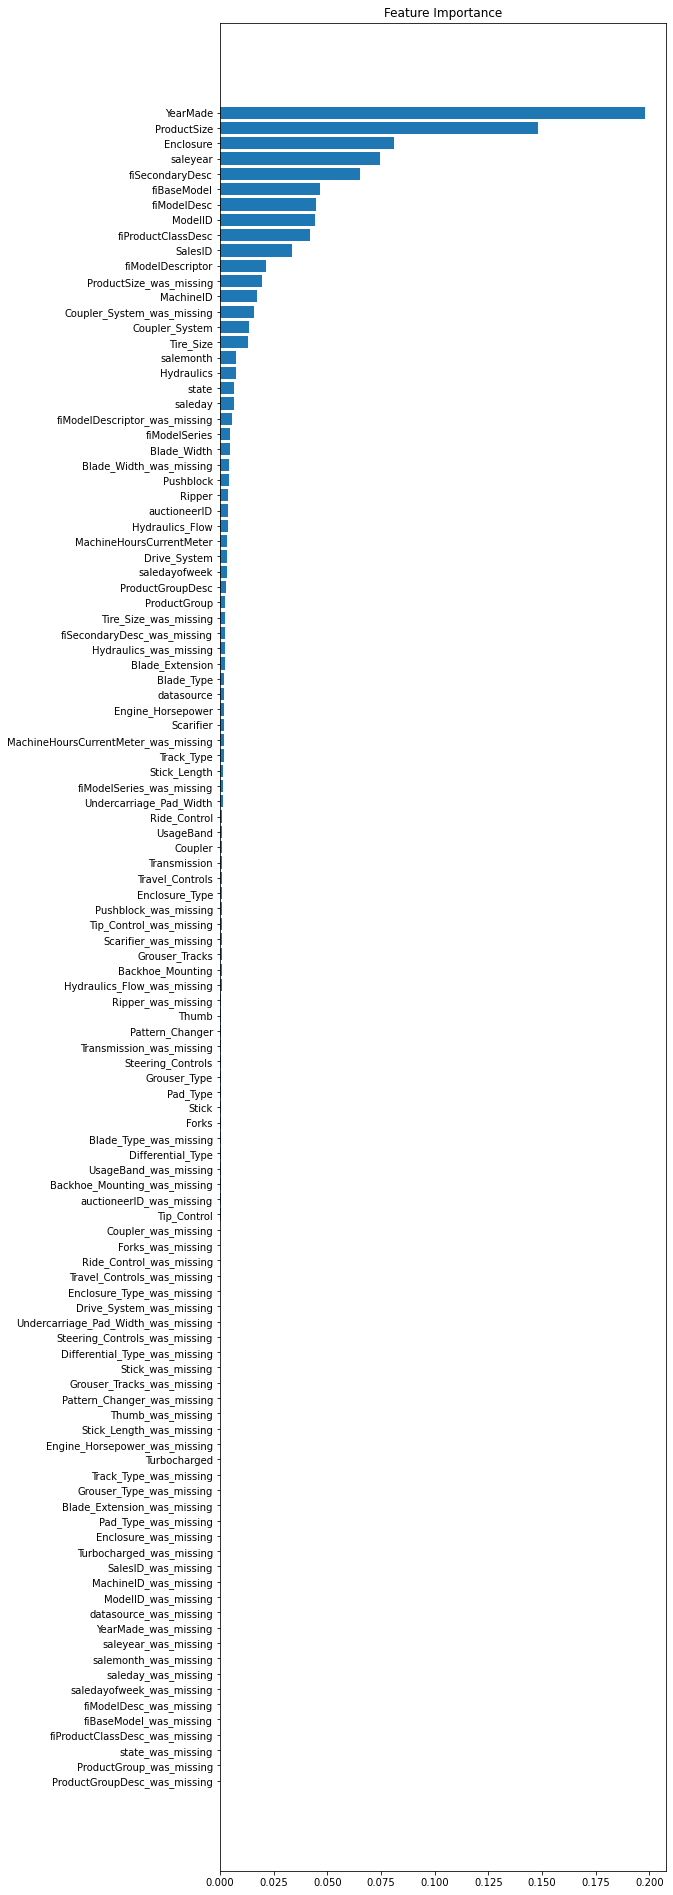

In [38]:
feature_importance_df = pd.DataFrame(ideal_model.feature_importances_, index=X_TRAIN.columns, columns=["Scores"])
feature_importance_df.sort_values("Scores", ascending=True, inplace=True)
fig ,ax = plt.subplots(figsize=(8,34))
ax.barh(feature_importance_df.index, feature_importance_df["Scores"], height=0.8)
ax.set_title("Feature Importance")
plt.show()